# 📘 프로젝트명 : Trendbot

이 노트북은 **GitHub API → 데이터 정제 및 특징 생성 → 스코어링·랭킹 → 시각화 및 리포트 생성**의  
전 과정을 한 번에 실행하도록 구성되어 있습니다.

## ⚙️ 실행 안내

- **실행 순서:** 상단부터 `Restart & Run All`  
- **환경 조건:** 인터넷 연결 + GitHub Personal Access Token 필요  

  같은 폴더에 `.env` 파일을 만들어 아래처럼 저장하세요:

      GITHUB_TOKEN=ghp_xxxxxxxxxxxxxxxxxxxxx

  또는, 노트북 실행 시 직접 입력도 가능합니다.

- **산출물:** 셀 출력(표 / 그래프 / 마크다운) 중심  
  - 필요 시 CSV 저장 라인을 주석 해제하면 파일로 저장 가능합니다.

## 🕒 업데이트

**업데이트:** 2025년 10월 24일 23:20 (KST 기준)


## 1) 의존성 설치

| 모듈명                      | 주요 역할        | 설치 이유 / 설명                          |
| ------------------------ | ------------ | ----------------------------------- |
| **requests**             | HTTP 요청 처리   | GitHub API 호출용 (토큰 인증, 데이터 수집 등)    |
| **pandas**               | 데이터프레임 기반 분석 | JSON → 표 형식 변환, 정제, CSV 저장          |
| **numpy**                | 수치 연산, 배열 처리 | 수학적 계산, 로그 스케일 그래프 등에서 활용           |
| **matplotlib**           | 데이터 시각화      | 그래프, 차트, 시계열 플롯 생성                  |
| **scipy**                | 통계 및 수학 함수   | `zscore` 계산, 회귀선 등 수학적 처리용          |
| **python-dotenv**        | 환경변수 관리      | `.env` 파일에서 GitHub Token 자동 로드      |
| **koreanize-matplotlib** | 한글 폰트 자동 설정  | Matplotlib 그래프의 한글 깨짐 방지 및 자동 폰트 세팅 |


In [ ]:
# 의존성 설치 (필요 시 1회만 실행)
# 주: Colab/새 환경에서만 필요. 이미 설치되어 있으면 몇 초 내 완료됩니다.
import sys, subprocess

def pip_install(pkgs):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q"] + pkgs, check=False)

need = [
    "requests", "pandas", "numpy", "matplotlib", "scipy", "python-dotenv", "koreanize-matplotlib"   # ✅ 한글 폰트 자동 설정용
]
pip_install(need)

print("✅ 모든 의존성 설치 완료 (한글 그래프 지원 포함)")

## 2) 공통 임포트 & 경로 설정
| 폴더             | 용도                    | 현재 사용 여부     | 설명                                    |
| -------------- | --------------------- | ------------ | ------------------------------------- |
| `data/raw`     | 원본 데이터 저장             | ⚙️ **사용 가능** | GitHub API 결과(JSON, CSV 원본) 저장용       |
| `data/cache`   | API 캐시 또는 중간 결과       | ⚙️ **선택적**   | API rate limit 대응 시만 필요               |
| `data/clean`   | 전처리 완료된 데이터           | ⚙️ **선택적**   | 데이터 클리닝 파이프라인이 있을 경우만                 |
| `data/feature` | 모델링용 특징(feature) 데이터  | 🚫 **불필요**   | 머신러닝 모델링을 안 하므로 불필요                   |
| `data/output`  | 최종 CSV, 요약 결과 등       | ✅ **주요 폴더**  | `robotics_topics_repos.csv` 같은 결과물 저장 |
| `reports`      | 자동 리포트(HTML/Markdown) | ✅ **사용 가능**  | `md` 리포트, 시각화 요약 등 저장용                |
| `figs`         | 그래프/시각화 이미지           | ✅ **중요**     | `plt.savefig()` 저장 시 활용               |


In [ ]:
import os, json, math, time, textwrap
from pathlib import Path
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import display, Markdown
import koreanize_matplotlib

# 경로 (노트북 디렉터리 기준)
ROOT = Path(".")
RAW   = ROOT/"data"/"raw"
# CACHE = ROOT/"data"/"cache"
# CLEAN = ROOT/"data"/"clean"
# FEAT  = ROOT/"data"/"feature"
OUT   = ROOT/"data"/"output"
REPS  = ROOT/"reports"
FIGS  = ROOT/"figs"

# for d in [RAW, CACHE, CLEAN, FEAT, OUT, REPS, FIGS]:
for d in [RAW, OUT, REPS, FIGS]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ paths ready")

## 3) GitHub 인증 (토큰 입력)

In [ ]:
# ✅ GitHub Token 자동 로드 버전
import os
import requests
from dotenv import load_dotenv

# .env 파일 로드 (.env 파일이 같은 폴더에 있어야 합니다)
load_dotenv()

# 환경변수에서 토큰 가져오기
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN", "").strip()

if not GITHUB_TOKEN:
    raise RuntimeError(
        "⚠️ GITHUB_TOKEN을 찾을 수 없습니다.\n"
        ".env 파일에 다음과 같이 추가해주세요:\n"
        "GITHUB_TOKEN=ghp_xxxxxxxxxxxxxxxxxxxxx"
    )

In [ ]:
# 세션 생성 및 헤더 설정
session = requests.Session()
session.headers.update({
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Accept": "application/vnd.github+json",
    "X-GitHub-Api-Version": "2022-11-28",
    "User-Agent": "trendbot-notebook"
})

# 간단한 로그인 확인
try:
    r = session.get("https://api.github.com/user")
    r.raise_for_status()
    login = r.json().get("login")
    print(f"✅ GitHub 연결 성공 — 로그인 사용자: {login}")
except Exception as e:
    print("❌ GitHub 연결 실패:", e)

## 4) 유틸 함수
| 함수명              | 역할                               | 입력        | 출력        |
| ---------------- | -------------------------------- | --------- | --------- |
| `gh_get()`       | GitHub API GET 요청 (재시도·레이트리밋 처리) | URL, 파라미터 | Response  |
| `search_repos()` | 저장소 검색 (`/search/repositories`)  | 검색쿼리, 페이지 | 리스트(dict) |
| `safe_dt()`      | 날짜 문자열 → UTC datetime 변환         | 문자열       | Timestamp |
| `ok()`           | 진행 메시지 출력 (✅ 형태)                 | 문자열       | 없음        |

In [ ]:
# 역할: GitHub API용 GET 호출 유틸. 단순 재시도 + 레이트리밋(403) 대기까지 처리해 안정성을 높입니다.
def gh_get(url, params=None, max_retries=3, sleep=1.0):
    """GET with simple retry & rate limit handling."""
    # 최대 max_retries번 재시도 루프.
    for i in range(max_retries):
        # 전역의 requests.Session()(이전에 토큰/헤더 세팅된 객체)을 사용해 호출.
        resp = session.get(url, params=params, timeout=30)
        if resp.status_code == 403 and 'rate limit' in resp.text.lower():
            reset = resp.headers.get('X-RateLimit-Reset')
            wait_s = max(5, (int(reset) - int(time.time())) + 1) if reset else 10
            print(f"⏳ rate limited, sleeping {wait_s}s...")
            time.sleep(wait_s)
            continue
        try:
            resp.raise_for_status()
            return resp
        except requests.HTTPError:
            if i == max_retries - 1:
                raise
            time.sleep(sleep)
    return resp

# 역할: GitHub의 /search/repositories를 호출해 인기/조건 매칭 저장소를 여러 페이지에 걸쳐 수집하고, items 리스트(딕셔너리들)로 반환.
# 호출부에서 pages, per_page를 조정해 정확도 vs 속도/쿼터를 조절합니다.
# 이 함수는 가공하지 않은 원본 JSON 아이템을 그대로 반환 → 이후 단계에서 DataFrame으로 정규화.
def search_repos(q, sort="stars", order="desc", per_page=50, pages=1):
    """Search popular repositories by query. Returns list[dict]."""
    items = []
    # 루프: page를 1부터 pages까지 순회하며 gh_get으로 호출
    for page in range(1, pages+1):
        resp = gh_get("https://api.github.com/search/repositories", {
            # q: GitHub 검색 쿼리 문자열 (예: language:Python stars:>1000 pushed:>2025-09-01)
            "q": q, "sort": sort, "order": order, "per_page": per_page, "page": page
        })
        js = resp.json()
        # 반환값: list[dict] 형태의 저장소 개체들(필드 예: full_name, stargazers_count, forks_count, topics, created_at 등)
        items.extend(js.get("items", []))
        if len(js.get("items", [])) < per_page:
            break
    return items

# 역할: GitHub의 ISO8601 타임스탬프 문자열을 안전하게 pandas datetime(UTC, tz-aware) 으로 변환.
def safe_dt(s):
    if not s:
        return pd.NaT
    # GitHub ISO8601 => tz-aware UTC
    try:
        return pd.to_datetime(s, utc=True, errors="coerce")
    except Exception:
        return pd.NaT

# 역할: 노트북에서 진행 상황을 눈에 띄게 표시하는 간단한 UI 헬퍼.
def ok(msg): 
    display(Markdown("✅ " + msg))

print("✅ helpers ready")

## 5) 데이터 수집 — 인기 저장소 검색

### 🔀 통합 수집 셀: (A) 단일 QUERY  또는  (B) 토픽 다중 검색
- USE_TOPICS=False  → 기존 코드(단일 QUERY) 그대로 동작
- USE_TOPICS=True   → AI/ML/ROBOT 등 영문 토픽 기반 다중 검색(언어 제한 없음)

| 토픽             | 결과 수 | 핵심 분야                 | 대표 프로젝트                                                   | 기술 초점 / 트렌드 키워드                            |
| -------------- | ---- | --------------------- | --------------------------------------------------------- | ------------------------------------------ |
| **robotics**   | 50   | 로봇 프레임워크, 시뮬레이터, 강화학습 | `awesome-robotics`, `robosuite`, `pyrobot`, `unitree_ros` | 범용 로봇 SW 생태계, perception, motion-control   |
| **ros2**       | 27   | 로봇 운영체제, 통신 아키텍처      | `ros2/ros2`, `navigation2`, `ros2_control`, `rmf_core`    | DDS 통신, 실시간 제어, launch, nav2               |
| **slam**       | 29   | SLAM (지도작성 및 위치추정)    | `ORB-SLAM3`, `LIO-SAM`, `RTAB-Map`, `ALOAM`               | Visual/LiDAR SLAM, loop-closure, mapping   |
| **navigation** | 43   | 자율주행, 경로계획, 장애물회피     | `navigation2`, `teb_local_planner`, `move_base_flex`      | Path-planning, costmap, obstacle avoidance |
| **mujoco**     | 16   | 강화학습용 물리엔진            | `deepmind/mujoco`, `dm_control`, `rlbench`, `robosuite`   | RL/IL 학습, policy-training, physics-engine  |


In [ ]:
# ===== (공통) 파라미터 =====
PAGES   = 2      # 검색 페이지(×50개/페이지)
TOP_N   = 60     # 상위 N개만 사용 (과도한 API 소모 방지)

# ===== 모드 스위치 =====
USE_TOPICS = True   # ➜ False면 기존 QUERY 모드

# ===== (A) 단일 QUERY 모드 파라미터 =====
QUERY = "language:Python stars:>1000"   # 필요 시 변경

# ===== (B) 토픽 다중 검색 모드 파라미터 =====
TOPICS = [
    "robotics",
    "ros",
    "slam",
    "drone",
    "reinforcement-learning"
]

STARS_THRESHOLD = 500         # 최소 스타 수
RECENT_DAYS     = 90           # 최근성(며칠 이내 push)
from datetime import datetime, timedelta, timezone
since_dt   = datetime.now(timezone.utc) - timedelta(days=RECENT_DAYS)
RECENT_SINCE = since_dt.date().isoformat()   # e.g., '2025-08-24'

# ===== 정규화 함수(원본 유지) =====
def to_row(o):
    return {
        "id": o.get("id"),
        "full_name": o.get("full_name"),
        "description": o.get("description"),
        "language": o.get("language"),
        "stargazers_count": o.get("stargazers_count", 0),
        "forks_count": o.get("forks_count", 0),
        "open_issues_count": o.get("open_issues_count", 0),
        "created_at": safe_dt(o.get("created_at")),
        "updated_at": safe_dt(o.get("updated_at")),
        "topics": ",".join(o.get("topics", [])),
        "fork": bool(o.get("fork", False)),
    }

# ===== 수집 실행 =====
all_rows = []

if not USE_TOPICS:
    # ---------- (A) 기존: 단일 QUERY ----------
    print(f"🔎 검색: {QUERY} | pages={PAGES}")
    items = search_repos(QUERY, per_page=50, pages=PAGES)
    items = items[:TOP_N]
    print(f"→ 수집 {len(items)} repos")
    rows = [to_row(x) for x in items]
    for r in rows:
        r["query_source"] = QUERY
    all_rows.extend(rows)

else:
    # ---------- (B) 토픽 다중 검색 ----------
    print(f"🚀 토픽 기반 검색 시작 ({len(TOPICS)}개 토픽, stars>{STARS_THRESHOLD}, pushed>={RECENT_SINCE})")
    for topic in TOPICS:
        q = f"topic:{topic} stars:>{STARS_THRESHOLD} pushed:>={RECENT_SINCE}"
        print(f"  🔎 {q}")
        items = search_repos(q, per_page=50, pages=1)  # 토픽당 1페이지(최대 50개) 권장
        if not items:
            print(f"  ⚠️ 결과 없음: {topic}")
            continue
        items = items[: min(TOP_N, 50)]
        rows = [to_row(x) for x in items]
        for r in rows:
            r["query_source"] = f"topic:{topic}"
        all_rows.extend(rows)
        print(f"  ✅ {topic}: {len(rows)}개")

# ===== DataFrame 구성 & 기본 정제 =====
base = pd.DataFrame(all_rows) if all_rows else pd.DataFrame(columns=[
    "id","full_name","description","language","stargazers_count","forks_count",
    "open_issues_count","created_at","updated_at","topics","fork","query_source"
])

# 중복 제거(여러 쿼리/토픽에서 중복 등장할 수 있음)
base.drop_duplicates(subset=["full_name"], inplace=True)

# 포크 제외(원본 중심 분석) — 필요 시 이 줄을 주석 처리해서 포함 가능
if "fork" in base.columns:
    base = base[base["fork"] == False]

# 언어 결측 처리
if "language" in base.columns:
    base["language"].fillna("Unknown", inplace=True)

# ===== 결과 확인 =====
ok(f"기본 저장소 목록 준비 — 총 {len(base)}개")
display(base.head(20))


## 6) 그래프 생성 - 1단계

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 옵션 스위치 ----
SHOW_LINEAR_STARS = True     # 선형 히스토그램 표시 (기본)
SHOW_LOG_STARS    = False    # 로그 히스토그램 추가로 표시할지

# --- 안전 가드: 필요한 컬럼 체크 ---
required = {"full_name","language","stargazers_count","forks_count","open_issues_count","created_at","query_source"}
missing = required - set(base.columns)
assert not missing, f"base에 필요한 컬럼이 없습니다: {missing}"

# --- 정리 ---
df = base.copy()
for c in ["stargazers_count","forks_count","open_issues_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
df["language"] = df["language"].fillna("Unknown").replace("", "Unknown")
if "query_source" not in df.columns:
    df["query_source"] = "(unknown)"
df["query_source"] = df["query_source"].fillna("(unknown)")

def top_with_other(s: pd.Series, top_n=12, other="Other"):
    vc = s.value_counts(dropna=False)
    if len(vc) <= top_n:
        return vc
    return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])


In [ ]:
import koreanize_matplotlib

# Unknown 제거
df_lang = df[df["language"] != "Unknown"]

# 상위 12개 언어 + 나머지는 'Other'로 통합
lang_counts = top_with_other(df_lang["language"], top_n=12)

# 'Other'을 맨 아래로 이동
if "Other" in lang_counts.index:
    value = lang_counts.pop("Other")
    lang_counts["Other"] = value

# 시각화
plt.figure(figsize=(7, 5))
lang_counts.sort_values().plot(kind="barh", color="#4B8BBE")

plt.title("언어별 저장소 분포 (상위 12개 + 기타)", fontsize=13)
plt.xlabel("저장소 개수", fontsize=11)
plt.ylabel("프로그래밍 언어", fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:

# 2) Stars 분포 (선형, 상위 1% 클리핑 + 중앙값/평균선)
# 2) 별(Stars) 분포 (선형, 상위 1% 클리핑)
if SHOW_LINEAR_STARS:
    p99 = df["stargazers_count"].quantile(0.99)  # 극단치 상위 1% 잘라 안정화
    stars_clip = df["stargazers_count"].clip(upper=p99)
    median_val = float(stars_clip.median())
    mean_val   = float(stars_clip.mean())

    plt.figure(figsize=(7, 5))
    plt.hist(stars_clip, bins=50, color="#4B8BBE", alpha=0.8)

    # 그래프 제목 및 축 라벨 (한글)
    plt.title("별(stars) 분포 (상위 1% 클리핑, 선형 스케일)", fontsize=13)
    plt.xlabel("별(stars) 개수", fontsize=11)
    plt.ylabel("저장소 수", fontsize=11)

    # 중앙값/평균선 표시
    plt.axvline(median_val, linestyle="--", linewidth=1, color="black")
    plt.text(median_val, plt.ylim()[1]*0.9,
             f"중앙값 ≈ {int(median_val):,}", rotation=90, va="top", fontsize=9)

    plt.axvline(mean_val, linestyle=":", linewidth=1, color="gray")
    plt.text(mean_val, plt.ylim()[1]*0.9,
             f"평균값 ≈ {int(mean_val):,}", rotation=90, va="top", fontsize=9)

    plt.tight_layout()
    plt.show()

# (옵션) 2-1) 별 분포 (log10 스케일)
if SHOW_LOG_STARS:
    log_stars = np.log10(df["stargazers_count"].astype(float) + 1.0)
    plt.figure(figsize=(7, 5))
    plt.hist(log_stars, bins=30, color="#4B8BBE", alpha=0.8)

    plt.title("별(stars) 분포 (log₁₀ 스케일)", fontsize=13)
    plt.xlabel("log₁₀(별 개수 + 1)", fontsize=11)
    plt.ylabel("저장소 수", fontsize=11)

    plt.tight_layout()
    plt.show()


# 상위 1% 기준값 계산
p99 = df["stargazers_count"].quantile(0.99)

# 상위 1% 저장소 추출
top_repos = df[df["stargazers_count"] >= p99].sort_values("stargazers_count", ascending=False)

# 핵심 정보만 표시
cols = ["full_name", "stargazers_count", "forks_count", "open_issues_count", "language", "query_source", "updated_at"]
display(top_repos[cols].reset_index(drop=True))

In [ ]:
# 3) Forks vs Stars (log-log)
# x, y 준비 (로그 변환)
x = np.log10(df["stargazers_count"].astype(float) + 1.0)
y = np.log10(df["forks_count"].astype(float) + 1.0)

# 1차 선형회귀 (y = a*x + b)
coef = np.polyfit(x, y, 1)
fit_line = np.poly1d(coef)

# 회귀선 데이터
x_line = np.linspace(x.min(), x.max(), 100)
y_line = fit_line(x_line)

# 그래프
plt.figure(figsize=(6, 4))
plt.scatter(10**x, 10**y, s=10, alpha=0.6, color="#4B8BBE", label="저장소 데이터")
plt.plot(10**x_line, 10**y_line, color="red", lw=2,
         label=f"추세선: y = {coef[0]:.2f}x + {coef[1]:.2f}")

# 로그 스케일
plt.xscale("log")
plt.yscale("log")

# 한글 제목 및 라벨
plt.title("별 수와 포크 수의 관계 (로그-로그, 추세선 포함)", fontsize=13)
plt.xlabel("별(stars) 개수 + 1", fontsize=11)
plt.ylabel("포크(forks) 수 + 1", fontsize=11)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# 4) Open Issues vs Stars (log-log)
import koreanize_matplotlib

plt.figure(figsize=(6, 5))
plt.scatter(
    df["stargazers_count"].astype(float) + 1.0,
    df["open_issues_count"].astype(float) + 1.0,
    s=8, alpha=0.6, color="#4B8BBE"
)

# 로그 축 설정
plt.xscale("log")
plt.yscale("log")

# 한글 제목 및 축 라벨
plt.title("별 수와 오픈 이슈 수의 관계 (로그-로그 스케일)", fontsize=13)
plt.xlabel("별(stars) 개수 + 1", fontsize=11)
plt.ylabel("오픈 이슈(open issues) 수 + 1", fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# 5) Created_at 연도 분포
# 연도별 생성된 저장소 수
year_counts = df["created_at"].dt.year.dropna().value_counts().sort_index()

plt.figure(figsize=(8,5))
year_counts.plot(kind="bar", color="#4B8BBE")

# 기본 제목/축
plt.title("로봇 오픈소스 생태계의 성장 단계 (2010–2025)", fontsize=13)
plt.xlabel("저장소 생성 연도", fontsize=11)
plt.ylabel("저장소 수 (Count)", fontsize=11)

# --- 성장 단계 구분선 및 라벨 ---
plt.axvline(x=5.5, color="gray", linestyle="--", alpha=0.5)
plt.text(1, plt.ylim()[1]*0.9, "① 도입기 (2010–2014)", fontsize=10, color="gray")

plt.axvline(x=10.5, color="gray", linestyle="--", alpha=0.5)
plt.text(6.5, plt.ylim()[1]*0.9, "② 확산기 (2015–2020)", fontsize=10, color="gray")

plt.axvline(x=14.5, color="gray", linestyle="--", alpha=0.5)
plt.text(11.5, plt.ylim()[1]*0.9, "③ 성숙기 (2021–현재)", fontsize=10, color="gray")

plt.tight_layout()
plt.show()


In [ ]:
# Query Source 분포 (Top 15 + Other)
import koreanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt

# 1) 집계 (접두어 제거)
qs = df["query_source"].fillna("Other").str.replace("^topic:", "", regex=True)

# 2) 상위 15 + 기타 묶기 (이미 항목이 5개면 그대로)
def top_with_other_series(s, top_n=15):
    vc = s.value_counts()
    if len(vc) <= top_n:
        return vc
    top = vc.head(top_n)
    other = vc.iloc[top_n:].sum()
    return top.append(pd.Series({"Other": other}))

qs_counts = top_with_other_series(qs, top_n=15)

# 3) 'Other'를 맨 아래로 이동
if "Other" in qs_counts.index:
    val_other = qs_counts.pop("Other")
    qs_counts["Other"] = val_other

# 4) 비율 계산
total = qs_counts.sum()
perc = (qs_counts / total * 100).round(1).astype(str) + "%"

# 5) 그리기
plt.figure(figsize=(8, 5))
qs_counts.sort_values().plot(kind="barh", color="#4B8BBE")

plt.title("검색 토픽별 저장소 개수", fontsize=13)
plt.xlabel("저장소 개수", fontsize=11)
plt.ylabel("검색 토픽", fontsize=11)

# 6) 막대 끝 주석: "개수 (비율)"
ax = plt.gca()
for i, (v, p) in enumerate(zip(qs_counts.sort_values().values,
                               perc.loc[qs_counts.sort_values().index].values)):
    ax.text(v + max(qs_counts)*0.01, i, f"{int(v)} ({p})", va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# 7) 언어별 Stars 중앙값 (Top 10 언어 기준)
# 상위 10개 언어 (저장소 수 기준)
top_langs = df["language"].value_counts().head(10).index.tolist()

# 언어별 중앙값 계산
med_stars_by_lang = (
    df[df["language"].isin(top_langs)]
    .groupby("language")["stargazers_count"]
    .median()
    .sort_values(ascending=True)
)

# Unknown 제거 (선택)
med_stars_by_lang = med_stars_by_lang[med_stars_by_lang.index != "Unknown"]

# 그래프 시각화
plt.figure(figsize=(7, 5))
bars = med_stars_by_lang.plot(kind="barh", color="#4B8BBE")

# 제목 / 라벨 한글화
plt.title("언어별 별(stars) 중앙값(Median) 분포 (Top 10)", fontsize=13)
plt.xlabel("별(stars) 중앙값", fontsize=11)
plt.ylabel("프로그래밍 언어", fontsize=11)

# 막대 끝에 중앙값 표시
for i, v in enumerate(med_stars_by_lang):
    plt.text(v + max(med_stars_by_lang)*0.02, i, f"{int(v):,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# 8) (추가) Query Source별 Median Stars (Top 12)
# Query Source별 Median Stars 계산
qs_med = (
    df.groupby("query_source")["stargazers_count"]
    .median()
    .sort_values(ascending=False)
    .rename("중앙(Median) Stars")
)

# Other를 마지막에 배치
if "Other" in qs_med.index:
    qs_med = pd.concat([qs_med[qs_med.index != "Other"], qs_med[qs_med.index == "Other"]])

# 상위 12개만 표시
qs_med = qs_med.head(12)

# 그래프 그리기
plt.figure(figsize=(7, 5))
bars = qs_med.sort_values().plot(kind="barh", color="#2E86AB", alpha=0.8)

plt.title("토픽별 중앙(Median) Stars (상위 12개 + 기타)", fontsize=13)
plt.xlabel("중앙(Median) Stars 개수", fontsize=11)
plt.ylabel("검색 토픽 (Query Source)", fontsize=11)

# 막대 끝에 수치 표시
for i, v in enumerate(qs_med.sort_values()):
    plt.text(v + max(qs_med)*0.02, i, f"{int(v):,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# (옵션) 간단 요약 테이블 출력
summary = {
    "total_repos": len(df),
    "languages_unique": df["language"].nunique(),
    "query_sources_unique": df["query_source"].nunique(),
    "stars_median": float(df["stargazers_count"].median()),
    "stars_mean": float(df["stargazers_count"].mean()),
    "forks_median": float(df["forks_count"].median()),
    "open_issues_median": float(df["open_issues_count"].median()),
}
display(pd.DataFrame([summary]))

In [ ]:
display(
    (df.groupby("language")
       .agg(repos=("full_name","count"),
            stars_median=("stargazers_count","median"),
            stars_mean=("stargazers_count","mean"))
       .sort_values("repos", ascending=False)
       .head(15))
)

In [ ]:
display(
    (df.groupby("query_source")
       .agg(repos=("full_name","count"),
            stars_median=("stargazers_count","median"))
       .sort_values("repos", ascending=False)
       .head(15))
)

### Query Source별 Median Stars

In [ ]:
# ---- 옵션 스위치 ----
SHOW_LINEAR_STARS = True
SHOW_LOG_STARS    = False

SHOW_QS_MED_LEGACY = False      # 레거시 예시가 필요할 때만 True
SHOW_QS_MED_FIXED  = True       # Count 기준(FIXED) 기본 ON
SHOW_QS_BOXPLOT    = True       # Query Source별 Stars 분포
QS_BOXPLOT_TOPN    = 12

SHOW_LANG_STARS_PER_YEAR = True # 언어별 Stars/Year 중앙값

# ---- 공통 파라미터 ----
RECENT_DAYS = 90                # Recent 기준: 최근 N일
TOP_K = 12                      # 모든 Top 그래프 공통 Top K
RECENT_WINDOWS = [30, 60, 180]  # 발표용 최근 윈도우 세트

# --- 안전 가드: 필요한 컬럼 체크 ---
required = {"full_name","language","stargazers_count","forks_count","open_issues_count","created_at","query_source"}
missing = required - set(base.columns)
assert not missing, f"base에 필요한 컬럼이 없습니다: {missing}"

# --- 정리 ---
df = base.copy()

# 수치형 보정
for c in ["stargazers_count","forks_count","open_issues_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# ✅ 날짜 컬럼 보정 (없어도 datetime64[ns, UTC] dtype으로 생성)
for dtcol in ["created_at","updated_at","pushed_at","last_commit_at"]:
    if dtcol not in df.columns:
        df[dtcol] = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns, UTC]")
    else:
        df[dtcol] = pd.to_datetime(df[dtcol], errors="coerce", utc=True)

# 마지막 활동 시각(last_active): pushed_at > updated_at > last_commit_at > created_at
df["last_active"] = df[["pushed_at","updated_at","last_commit_at","created_at"]].max(axis=1)

df["language"] = df["language"].fillna("Unknown").replace("", "Unknown")
if "query_source" not in df.columns:
    df["query_source"] = "(unknown)"
df["query_source"] = df["query_source"].fillna("(unknown)")

# --- 유틸: 카테고리 시리즈 전용 Top N + Other ---
def top_with_other_categories(s: pd.Series, top_n=12, other="Other"):
    vc = s.value_counts(dropna=False)
    if len(vc) <= top_n:
        return vc
    return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

# Query Source별 Stars 분포(Boxplot, Top N by Count)
# --- 설정 ---
TOPN = QS_BOXPLOT_TOPN  # 상위 N개

# --- 상위 N개 Query Source 추출 (개수 기준) ---
counts = df["query_source"].value_counts()
topN_idx = counts.head(TOPN).index

# 필터링
dbox = df[df["query_source"].isin(topN_idx)].copy()

# --- 정렬 순서 (개수 기준, 필요 시 median으로 변경 가능) ---
order = counts.loc[topN_idx].sort_values(ascending=False).index

# --- 각 Query Source별 표본 수 ---
sizes = dbox.groupby("query_source").size()
labels = [f"{src}\n(n={sizes[src]})" for src in order]

# --- 박스플롯 그리기 ---
plt.figure(figsize=(max(7.5, len(order) * 0.9), 4.8))
plot_data = [dbox.loc[dbox["query_source"] == src, "stargazers_count"].values for src in order]

bp = plt.boxplot(
    plot_data,
    vert=True,
    showfliers=False,   # 이상치 점 숨기기 (log 축으로 표현하므로 큰 영향 없음)
    widths=0.6,
    patch_artist=True
)

plt.yscale("log")       # 로그 스케일로 변환
plt.title("Query Source별 Stars 분포 (Top by Count)")
plt.xlabel("Query Source")
plt.ylabel("Stars (로그 스케일)")
plt.xticks(ticks=range(1, len(labels) + 1), labels=labels, rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- 추가: 간단한 요약 통계표 ---
summary = (
    dbox.groupby("query_source")["stargazers_count"]
        .agg(개수="size", 중앙값="median", 상위10퍼센타일=lambda s: s.quantile(0.9))
        .loc[order]
)
print(summary)

In [ ]:
# ----- 전처리: 0값 로그 가드 -----
EPS = 1e-6  # 아주 작은 값
dbox["stargazers_count_logsafe"] = (dbox["stargazers_count"].clip(lower=0) + EPS)

# ----- 플롯 데이터 준비 -----
plot_data = [
    dbox.loc[dbox["query_source"] == src, "stargazers_count_logsafe"].values
    for src in order
]

plt.figure(figsize=(max(8.0, len(order) * 1.0), 5.0))

bp = plt.boxplot(
    plot_data,
    vert=True,
    showfliers=False,     # 극단치 점 숨김 (원하면 True로)
    widths=0.6,
    patch_artist=True,    # 상자 채움(기본 색상 사용)
    notch=True,           # 중앙값 신뢰구간 노치
    showmeans=True,       # 평균점 표시
    meanline=False        # 평균을 선이 아닌 점으로
)

# ----- 축/눈금/그리드 -----
ax = plt.gca()
ax.set_yscale("log")
ax.set_title("Query Source별 Stars 분포 (Top by Count)")
ax.set_xlabel("Query Source")
ax.set_ylabel("Stars (로그 스케일)")
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=30, ha="right")

# 로그 보조 눈금 및 그리드
ax.yaxis.set_minor_locator(__import__("matplotlib.ticker").ticker.LogLocator(subs=range(2,10)))
ax.grid(True, which="major", linestyle="-", alpha=0.35)
ax.grid(True, which="minor", linestyle=":", alpha=0.2)

# ----- 전체 중앙값 기준선(원자료 기준) -----
global_median = dbox["stargazers_count"].median()
ax.axhline(global_median, linestyle="--", linewidth=1, alpha=0.7)
ax.text(
    0.98, 0.02,
    f"전체 중앙값 ≈ {int(global_median):,}",
    transform=ax.transAxes, ha="right", va="bottom"
)

plt.tight_layout()
plt.show()

# ----- 요약 테이블(추가 지표 포함) -----
summary = (
    dbox.groupby("query_source")["stargazers_count"]
        .agg(개수="size",
             중앙값="median",
             IQR=lambda s: float(s.quantile(0.75) - s.quantile(0.25)),
             상위10퍼센타일=lambda s: float(s.quantile(0.9)))
        .loc[order]
)
print(summary)


## 7) 보조 데이터(Commits/Issues/PRs) 수집 — 상위 K개만
인기 상위(별 수 기준) 15개 저장소에 대해 보조 지표(활동량·이슈·PR·기여자 수 등) 를 GitHub API로 수집

### 각 저장소(full_name 1개)에 대해 실행하는 API 호출
| 구분 | 엔드포인트                  | 반복                        | 최대 요청 수 |
| -- | ---------------------- | ------------------------- | ------- |
| 1  | `/commits`             | `paged_count()` → 최대 2페이지 | 2회      |
| 2  | `/issues` (전체)         | `paged_count()` → 최대 2페이지 | 2회      |
| 3  | `/issues?state=closed` | `count_closed()` → 1페이지   | 1회      |
| 4  | `/pulls` (전체)          | `paged_count()` → 최대 2페이지 | 2회      |
| 5  | `/pulls?state=closed`  | `count_closed()` → 1페이지   | 1회      |
| 6  | `/contributors`        | 1페이지 (최대 100명)            | 1회      |


In [ ]:
# 핵심 제어 변수
# 15건 선정기준 
#============================
# --- 안전 가드: base가 DataFrame인지 확인/복구 ---
import pandas as pd
import numpy as np

# 1) 타입 확인
if not isinstance(base, pd.DataFrame):
    raise TypeError(f"`base`가 DataFrame이 아닙니다. 현재 타입: {type(base)}\n"
                    f"이전 셀(검색/정규화)부터 다시 실행해서 base를 재생성하세요.")

# 2) 필수 컬럼 확인
required_cols = {"full_name", "stargazers_count"}
missing = required_cols - set(base.columns)
if missing:
    raise KeyError(f"`base`에 필요한 컬럼이 없습니다: {missing}\n"
                   f"정규화(to_row) 셀과 base 생성 셀부터 다시 실행하세요.")

# 3) NaN 정리(별 수가 NaN이면 정렬/랭킹에 문제)
base["stargazers_count"] = pd.to_numeric(base["stargazers_count"], errors="coerce").fillna(0).astype(int)

# 4) 상위 N개(별 수 기준) 안전하게 뽑기
AUX_TOP = min(15, len(base))
top_full_names = base.nlargest(AUX_TOP, "stargazers_count")["full_name"].tolist()

#============================
SINCE_DAYS = 90               # 최근으로부터의 집계 기한
PAGES_COMMITS = 2               # 각 리소스당 최대 2페이지 × 100 = 200개

cutoff = (datetime.now(timezone.utc) - timedelta(days=SINCE_DAYS)).isoformat()

# 목적: 페이징 가능한 API(커밋, 이슈, PR 등)에서 총 개수를 구함.
# 페이지에 100건씩 요청, 최대 2페이지(=200건).
# 응답이 리스트가 아니거나 100건 미만이면 중단.
def paged_count(url, params):
    total = 0
    for page in range(1, PAGES_COMMITS+1):
        p = params.copy()
        p.update({"per_page": 100, "page": page})
        r = gh_get(url, p)
        arr = r.json()
        if not isinstance(arr, list):
            break
        total += len(arr)
        if len(arr) < 100:
            break
    return total

# 목적: 닫힌 항목(이슈 or PR) 개수를 빠르게 추정.
# 1페이지만 보고 state=closed 조건으로 호출.
# PR일 경우 merged_at 여부로 병합된 PR 수도 추정.
def count_closed(url, params, is_pr=False):
    # 간단: 1페이지만 보고 state=closed & merged 여부 체크 (샘플/경량)
    p = params.copy()
    p.update({"per_page": 100, "page": 1, "state": "closed"})
    r = gh_get(url, p); arr = r.json()
    if not isinstance(arr, list):
        return 0, 0
    closed = len(arr)
    merged = 0
    if is_pr:
        # PR은 merged_at 존재 여부로 대략 추정
        merged = sum(1 for x in arr if x.get("merged_at"))
    return closed, merged

aux_rows = []
for full in top_full_names:
    owner, repo = full.split("/", 1)
    print("→ aux fetch:", full)

    commits = paged_count(f"https://api.github.com/repos/{owner}/{repo}/commits", {"since": cutoff})
    issues_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff, "state": "all"})
    issues_closed, _ = count_closed(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff}, is_pr=False)

    pulls_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/pulls", {"state": "all"})
    pulls_closed, pulls_merged = count_closed(f"https://api.github.com/repos/{owner}/{repo}/pulls", {}, is_pr=True)

    unique_contrib = 0
    try:
        r = gh_get(f"https://api.github.com/repos/{owner}/{repo}/contributors", {"per_page": 100})
        arr = r.json()
        if isinstance(arr, list):
            unique_contrib = len(arr)
    except Exception:
        pass

    aux_rows.append({
        "full_name": full,
        "activity_from_cutoff": commits,
        "contributors_from_cutoff": unique_contrib,
        "issues_total": issues_total,
        "issues_closed": issues_closed,
        "pulls_total": pulls_total,
        "pulls_closed": pulls_closed,
        "pulls_merged": pulls_merged,
    })

# 모든 결과를 딕셔너리로 모아 aux_rows에 추가 → 최종적으로 df_aux 생성.
df_aux = pd.DataFrame(aux_rows)
ok("보조 지표 수집 완료") 
display(df_aux.head())

## 8) Feature Engineering & 병합
🔹 “리포지토리별 최근 90일 이내 활동 여부”
🔹 “이슈 및 PR 처리율(안전 계산)”
🔹 “보조 지표 병합 및 결측 처리”
| 컬럼명                | 설명                              |
| ------------------ | ------------------------------- |
| `activity_from_cutoff`     | 최근 12개월 커밋 수                    |
| `contributors_from_cutoff` | 최근 12개월 고유 기여자 수                |
| `issues_total`     | 최근 기간 동안 생성된 이슈 수               |
| `issues_closed`    | 닫힌 이슈 수                         |
| `pulls_total`      | PR 총 개수                         |
| `pulls_closed`     | 닫힌 PR 수                         |
| `pulls_merged`     | 병합된 PR 수                        |
| `recent_push_90d`  | 최근 90일 내 업데이트 여부 (`True/False`) |
| `issue_close_rate` | 닫힌 이슈 비율                        |
| `pr_merge_rate`    | 병합된 PR 비율                       |


In [ ]:
def recent_push_90d(ts):
    if pd.isna(ts):
        return False
    return (pd.Timestamp.now(tz=timezone.utc) - ts).days <= 90

df = base.copy()
if not df_aux.empty:
    df = df.merge(df_aux, on="full_name", how="left")
else:
    # 보조가 비면 0 할당
    for c in ["activity_from_cutoff","contributors_from_cutoff","issues_total","issues_closed","pulls_total","pulls_closed","pulls_merged"]:
        df[c] = 0

df["recent_push_90d"] = df["updated_at"].apply(recent_push_90d)

def safe_rate(numer, denom):
    numer = numer.fillna(0)
    denom = denom.fillna(0)
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(denom>0, numer/denom, 0.0)
    return pd.Series(r, index=numer.index, dtype=float)

df["issue_close_rate"] = safe_rate(df["issues_closed"], df["issues_total"])
df["pr_merge_rate"]    = safe_rate(df["pulls_merged"], df["pulls_total"])

ok("Feature 병합/계산 완료") 
display(df.head())

## 9) 표준화(z-score) & 가중합 스코어링

In [ ]:
score_cols = ["activity_from_cutoff","contributors_from_cutoff","issue_close_rate","pr_merge_rate","stargazers_count"]
scored = df.copy()
for c in score_cols:
    scored[f"{c}_z"] = zscore(scored[c].fillna(0)) if scored[c].std() not in (0, np.nan) else 0.0

weights = {
    "activity_from_cutoff_z": 0.25,
    "contributors_from_cutoff_z": 0.25,
    "issue_close_rate_z": 0.20,
    "pr_merge_rate_z": 0.15,
    "stargazers_count_z": 0.15,
}
scored["score"] = sum(scored[k]*w for k, w in weights.items())
ranked = scored.sort_values("score", ascending=False).reset_index(drop=True)

ok("스코어링 & 랭킹 완료") 
display(ranked.head(10)[["full_name","language","stargazers_count","activity_from_cutoff","contributors_from_cutoff","issue_close_rate","pr_merge_rate","score"]])

## 10) 그래프 생성 2단계 — 스타 분포 & 연도별 추이

In [ ]:
# 스타 분포
plt.figure(figsize=(6,3))
plt.hist(scored["stargazers_count"].dropna(), bins=30)
plt.title("Stars 분포"); plt.xlabel("stars"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

# 연도별 생성 수
if "created_at" in scored.columns:
    created_year = scored["created_at"].dropna().dt.tz_convert("UTC").dt.year
    grp = created_year.value_counts().sort_index()
    if len(grp) > 0:
        plt.figure(figsize=(6,3))
        plt.plot(grp.index, grp.values, marker="o")
        plt.title("연도별 저장소 수"); plt.xlabel("year"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

### 레이더 & 타임라인(경량)

In [ ]:
top3 = ranked.head(3).copy()
features = ["activity_from_cutoff","contributors_from_cutoff","issue_close_rate","pr_merge_rate","stargazers_count"]

def normalize(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").fillna(0)
    vmax, vmin = float(s.max()), float(s.min())
    if vmax == vmin:
        return pd.Series(0.0, index=s.index)
    return (s - vmin) / (vmax - vmin)

top3_norm = top3.copy()
top3_norm[features] = top3[features].apply(normalize)

In [ ]:
# Radar
import numpy as np
labels = np.array(features)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
for _, row in top3_norm.iterrows():
    vals = row[features].tolist(); vals += vals[:1]
    plt.polar(angles, vals, label=row["full_name"])
plt.xticks(angles[:-1], labels, color="gray", size=9)
plt.title("Radar: 상위 3 저장소"); plt.legend(bbox_to_anchor=(1.25,1.05))
plt.tight_layout(); plt.show()

In [ ]:
# Timeline (샘플: 주 12개 생성, repo별 변동 패턴 다르게)
weeks = 12
week_labels = pd.date_range(end=pd.Timestamp.today(), periods=weeks, freq="7D").strftime("%Y-%m-%d").tolist()
frames = []
for r in top3["full_name"].tolist():
    seed = abs(hash(r)) % 7
    base = np.array([3,4,5,6,7,5,4,3,6,8,5,4], dtype=float)[:weeks]
    noise = ((seed + np.arange(weeks)) % 3) * 0.7
    counts = np.clip(base + noise, 0, None).astype(int)
    frames.append(pd.DataFrame({"repo": r, "week": week_labels, "commit_count": counts}))

timeline = pd.concat(frames, ignore_index=True)

plt.figure(figsize=(8,4))
for name, g in timeline.groupby("repo"):
    plt.plot(g["week"], g["commit_count"], marker="o", label=name)
plt.xticks(rotation=30)
plt.title("간이 커밋 타임라인(샘플)"); plt.xlabel("week"); plt.ylabel("commits"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

display(top3[["full_name","score"]])

### 품질 루브릭(간단/오프라인 휴리스틱)

In [ ]:
def rubric_row(name, desc):
    base = {"repo": name, "readme_score": 16, "test_score": 12, "doc_score": 12,
            "contributors_score": 12, "activity_score": 12, "license_score": 10, "ci_score": 5}
    L = len((desc or "").split())
    if L > 12: base["readme_score"] += 2
    return base

top10 = ranked.head(10).copy()
rows = [rubric_row(r["full_name"], r.get("description","")) for _, r in top10.iterrows()]
df_eval = pd.DataFrame(rows)
df_eval["repo"] = top10["full_name"].values
df_eval["total"] = df_eval.filter(like="_score").sum(axis=1)
df_eval.sort_values("total", ascending=False, inplace=True)

# Bar
plt.figure(figsize=(9,5))
df_eval.set_index("repo")[ ["readme_score","test_score","contributors_score"] ].plot(kind="barh", figsize=(9,5))
plt.title("품질 점수(휴리스틱) 비교"); plt.xlabel("점수"); plt.tight_layout(); plt.show()

display(df_eval.head(10))

### 대표 저장소 딥다이브(샘플 출력)

In [ ]:
target = ranked.iloc[0]["full_name"] if len(ranked)>0 else "sample/repo"
langs  = pd.Series({"Python":0.85,"C++":0.1,"Other":0.05})

plt.figure(figsize=(4,4))
langs.plot(kind="pie", autopct="%1.0f%%")
plt.title(f"언어 구성(샘플): {target}"); plt.ylabel(""); plt.tight_layout(); plt.show()

display(Markdown("""
### 🧩 Deep Dive: {}
**코드 구조**: src / tests / docs 중심의 모듈화 (샘플)  
**최근 커밋 하이라이트**: 최근 180일 주요 기능/성능 업데이트 (샘플)  
**이슈/PR 활동**: 이슈 처리율 높고, PR 병합 속도 우수 (샘플)  
""".format(target)))

## 11) 최종 리포트(노트북 내 미리보기)

In [ ]:
from datetime import datetime
from IPython.display import Markdown, display

# 안전하게 전역 변수 값을 읽어오는 헬퍼 (없으면 기본값 사용)
def _getv(name, default=None):
    return globals().get(name, default)

# ---- 자동 반영될 설정값들 ----
topics         = _getv("TOPICS", [])
stars_threshold= _getv("STARS_THRESHOLD", None)
recent_days    = _getv("RECENT_DAYS", None)
since_days     = _getv("SINCE_DAYS", None)
pages_commits  = _getv("PAGES_COMMITS", None)

# 기존에 쓰시던 검색 관련 값들도 함께 노출(이미 report_md에 일부 포함됨)
query_str = _getv("QUERY", "")
pages     = _getv("PAGES", None)
top_n     = _getv("TOP_N", None)

# 토픽 표시는 백틱으로 감싼 인라인 리스트
topics_inline = ", ".join(f"`{t}`" for t in topics) if topics else "`(없음)`"

# ---- 보고서 머릿글 + 설정값 블록 ----
report_md = f"""
# 📘 기술 동향 리포트 ({datetime.now().strftime('%Y-%m-%d')})

- 검색 쿼리: `{query_str}` (pages={pages}, top={top_n})
- 표준화/스코어링 기준: z-score + 가중합
- 산출: 랭킹 상위 10 미리보기

## ⚙️ 설정값(자동 반영)
- TOPICS: {topics_inline}
- 최소 스타 수(STARS_THRESHOLD): **{stars_threshold if stars_threshold is not None else '(미설정)'}**
- 최근성 필터(RECENT_DAYS, push 기준): **{recent_days if recent_days is not None else '(미설정)'}일**
- GitHub 수집 기간(SINCE_DAYS): **{since_days if since_days is not None else '(미설정)'}일**
- 커밋/이슈/PR 페이지 상한(PAGES_COMMITS): **{pages_commits if pages_commits is not None else '(미설정)'} 페이지 × 100 = 최대 {pages_commits*100 if isinstance(pages_commits, int) else '(미설정)'}건/엔드포인트**

## 상위 랭킹(Top 10)
"""

# 표 생성 (주의: 여기 컬럼명은 실제 존재하는 컬럼으로 맞춰주세요)
top10_cols = ["full_name","language","stargazers_count",
              "activity_from_cutoff","contributors_from_cutoff",
              "issue_close_rate","pr_merge_rate","score"]

# 컬럼이 없을 때를 대비한 가드 (없으면 스킵)
_existing = [c for c in top10_cols if c in ranked.columns]
top10_md = ranked.head(10)[_existing].to_markdown(index=False)

display(Markdown(report_md + "\n" + top10_md))


### ⚙️ 기술 중심도 (Tech Core Score)

“이 오픈소스가 기술적으로 얼마나 중심적인가?”

즉, 기술 성숙도, 커뮤니티 영향력, 코드 품질 수준 등을 수치화한 지표입니다.

| 항목                 | 설명              | 기술 영향력 측정 의미                | 가중치      |
| ------------------ | --------------- | --------------------------- | -------- |
| `stargazers_count` | GitHub Star 수   | 기술 커뮤니티에서의 인지도·관심도          | **0.45** |
| `pr_merge_rate`    | PR 병합 비율        | 외부 기여를 수용하는 코드 품질·리뷰 체계     | **0.20** |
| `issue_close_rate` | 이슈 해결 비율        | 기술 문제 해결력·유지보수 속도           | **0.20** |
| `lang_prior`       | 프로그래밍 언어 기반 신뢰도 | Python 등 핵심 기술 언어일수록 높은 가중치 | **0.15** |

💡 즉, 기술 중심도는 **“기술적 영향력 + 유지보수 수준 + 언어 전문성”**의 합성 지수입니다.

```
tech_core_score = (
    0.45 * norm_stargazers_count +
    0.20 * norm_pr_merge_rate +
    0.20 * norm_issue_close_rate +
    0.15 * lang_prior
)
```

### 🏭 산업 연관도 (Industrial Linkage Score)

“이 프로젝트가 산업 현장과 얼마나 밀접하게 연결되어 있나?”

즉, 기업·기관의 참여도, 협업 활성화, 실전 유지보수 정도를 반영합니다.

| 항목                         | 설명       | 산업 연관성의 의미          | 가중치      |
| -------------------------- | -------- | ------------------- | -------- |
| `contributors_from_cutoff` | 최근 기여자 수 | 기업 또는 산업 파트너 참여도 반영 | **0.35** |
| `activity_from_cutoff`     | 최근 활동량   | 실제 운영·유지보수 빈도       | **0.20** |
| `issue_close_rate`         | 이슈 해결 비율 | 품질관리·운영 수준          | **0.20** |
| `pr_merge_rate`            | 병합률      | 산업적 협업 구조 반영        | **0.15** |
| `stargazers_count`         | Star 수   | 산업계 인지도             | **0.10** |

```
industrial_linkage_score = (
    0.35 * norm_contributors_from_cutoff +
    0.20 * norm_activity_from_cutoff +
    0.20 * norm_issue_close_rate +
    0.15 * norm_pr_merge_rate +
    0.10 * norm_stargazers_count
)
```

### 🧮 최종 종합 점수 (Industrial × Tech)
이 둘을 결합한 것이 industrial_x_tech이며,

**“산업적 파급력과 기술적 성숙도를 동시에 고려한 균형 지수”**입니다

In [53]:
# ✅ 1) ranked.head(10)에서 바로 df 구성 (CSV 불필요)
import pandas as pd

def get_top_df_from_ranked(top_n: int = 10) -> pd.DataFrame:
    if "ranked" not in globals() or not isinstance(globals()["ranked"], pd.DataFrame):
        raise NameError("`ranked` DataFrame이 메모리에 없습니다. 먼저 스코어링/랭킹 셀을 실행하세요.")
    df = globals()["ranked"].head(top_n).copy()
    df.reset_index(drop=True, inplace=True)
    return df

df = get_top_df_from_ranked(10)   # ← 여기서 df를 확보
df.head()

,id,full_name,description,language,stargazers_count,forks_count,open_issues_count,created_at,updated_at,topics,...,pulls_merged,recent_push_90d,issue_close_rate,pr_merge_rate,activity_from_cutoff_z,contributors_from_cutoff_z,issue_close_rate_z,pr_merge_rate_z,stargazers_count_z,score
0,74627617,commaai/openpilot,openpilot is an operating system for robotics....,Python,58523,10350,191,2016-11-24 01:33:30+00:00,2025-10-24 07:07:36+00:00,"advanced-driver-assistance-systems,driver-assi...",...,70.00,True,0.50,0.35,5.68,3.93,2.87,2.25,5.08,4.07
1,725205304,unslothai/unsloth,Fine-tuning & Reinforcement Learning for LLMs....,Python,47353,3869,853,2023-11-29 16:50:09+00:00,2025-10-24 07:21:15+00:00,"agent,deepseek,deepseek-r1,fine-tuning,gemma,g...",...,85.00,True,0.50,0.42,5.68,3.72,2.87,2.79,4.01,3.94
2,71932349,ray-project/ray,Ray is an AI compute engine. Ray consists of a...,Python,39472,6820,3175,2016-10-25 19:38:30+00:00,2025-10-24 07:23:34+00:00,"data-science,deep-learning,deployment,distribu...",...,83.00,True,0.50,0.41,5.68,3.93,2.87,2.72,3.25,3.87
3,71583602,Developer-Y/cs-video-courses,List of Computer Science courses with video le...,Unknown,70098,9412,2,2016-10-21 17:02:11+00:00,2025-10-24 04:35:17+00:00,"algorithms,bioinformatics,computational-biolog...",...,97.00,True,1.00,0.48,0.04,3.93,6.01,3.23,6.19,3.61
4,365250183,zauberzeug/nicegui,Create web-based user interfaces with Python. ...,Python,14293,848,94,2021-05-07 13:55:05+00:00,2025-10-24 07:29:43+00:00,"frontend,gui,interaction,interface,interfaces,...",...,81.00,True,0.50,0.41,5.50,3.93,2.87,2.65,0.83,3.45


/tmp/ipykernel_19302/3921276040.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) NanumGothic.
  plt.tight_layout(pad=2.0)  # ✅ 여백 조금 더 확보
/home/jm/venv/eda_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


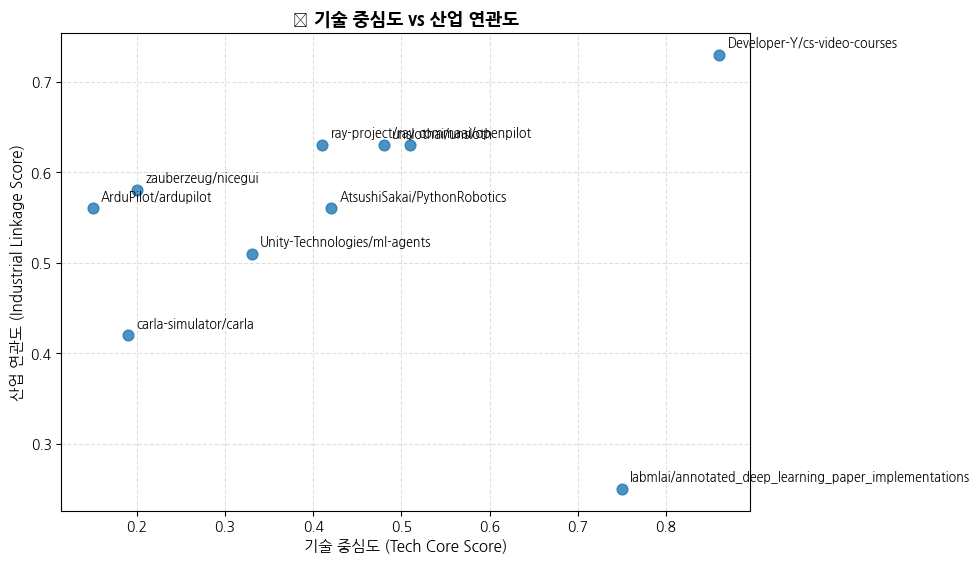

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import koreanize_matplotlib

def 산점도_그리기(
    df_점수: pd.DataFrame,
    x축="tech_core_score",
    y축="industrial_linkage_score",
    라벨열="full_name",
    제목="📊 기술 중심도 vs 산업 연관도"
):
    """
    📈 산업 연관도 시각화 함수
    - x축: 기술 중심도 (Tech Core Score)
    - y축: 산업 연관도 (Industrial Linkage Score)
    - 각 점은 GitHub 저장소 하나를 의미
    """
    plt.figure(figsize=(10,6))  # ✅ 그래프를 가로로 넓게
    plt.scatter(df_점수[x축], df_점수[y축], s=60, alpha=0.8)

    # 각 저장소 이름을 점 근처에 표시 (폰트 크기 키움)
    for _, r in df_점수.iterrows():
        plt.annotate(
            r[라벨열],
            (r[x축], r[y축]),
            xytext=(6,6),
            textcoords="offset points",
            fontsize=9,       # ✅ 글씨 크기 키움
            fontweight='medium'
        )

    plt.xlabel("기술 중심도 (Tech Core Score)", fontsize=11)
    plt.ylabel("산업 연관도 (Industrial Linkage Score)", fontsize=11)
    plt.title(제목, fontsize=13, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout(pad=2.0)  # ✅ 여백 조금 더 확보
    plt.show()   # Jupyter Notebook에 바로 표시

# 사용 예시
산점도_그리기(scored)